In [1]:
spark.version

'3.1.3'

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
bucket_write = 'msca-bdp-students-bucket'

In [5]:
education_influence3 = spark.read.parquet('gs://' + bucket_write + '/shared_data/paraut/tweets/')

22/12/07 19:19:54 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [28]:
education_influence3.count()

11756013

22/12/07 08:14:33 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 15 on hub-msca-bdp-dphub-students-paraut-sw-szx7.c.msca-bdp-students.internal: Container marked as failed: container_1670396608784_0004_01_000015 on host: hub-msca-bdp-dphub-students-paraut-sw-szx7.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/07 08:14:33 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 15 for reason Container marked as failed: container_1670396608784_0004_01_000015 on host: hub-msca-bdp-dphub-students-paraut-sw-szx7.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


In [27]:
education_influence3.groupBy('verified_user').count().show()

+-------------+--------+
|verified_user|   count|
+-------------+--------+
|         true|  113715|
|        false|11642298|
+-------------+--------+



In [6]:
time = education_influence3.select(['id','created_at'])

In [7]:
from pyspark.sql.functions import split

In [8]:
time1 = time.withColumn('weekday', split(time['created_at'], ' ').getItem(0)) \
            .withColumn('month', split(time['created_at'], ' ').getItem(1)) \
            .withColumn('day', split(time['created_at'], ' ').getItem(2)) \
            .withColumn('time', split(time['created_at'], ' ').getItem(3)) \
            .withColumn('0000', split(time['created_at'], ' ').getItem(4)) \
            .withColumn('year', split(time['created_at'], ' ').getItem(5))

In [9]:
time2 = time1.withColumn("month_number",from_unixtime(unix_timestamp(col("month"),'MMM'),'MM'))

In [10]:
time3 = time2.withColumn("merge", concat_ws("-", "month_number", "day", "year")) \
  .withColumn("date", to_date(unix_timestamp("merge", "MM-dd-yyyy").cast("timestamp"))).drop("merge")

In [11]:
time4 = time3.drop("created_at")\
        .drop("weekday")\
        .drop("month")\
        .drop("day")\
        .drop("time")\
        .drop("0000")\
        .drop("year")\
        .drop("month_number")

In [13]:
time4

id,date
1578043953550606337,2022-10-06
1524837223882862592,2022-05-12
1567342333766828033,2022-09-07
1588017706938552320,2022-11-03
1584698051595505664,2022-10-25
1532388983954558979,2022-06-02
1546291513910509568,2022-07-11
1580252402065686528,2022-10-12
1515156269442781185,2022-04-16
1533529437400080385,2022-06-05


In [12]:
time5 = time4.dropDuplicates(['id'])

In [13]:
joined_df = education_influence3.join(time5, "id", "left")

In [14]:
timeseries = joined_df.select(["date", "Organization"]).groupBy("Organization", "date").count()

In [17]:
timeseries

Organization,date,count
Other,2022-11-04,57366
School,2022-09-17,3
News,2022-09-07,141
Influencer,2022-10-10,232
Other,2022-10-22,44747
Other,2022-07-07,50495
News,2022-09-16,124
Influencer,2022-11-03,228
Other,2022-04-12,69395
Other,2022-07-20,46594


In [18]:
timeseries = timeseries.filter(timeseries.Organization != "Other")

In [19]:
pd_timeseries = timeseries.toPandas()

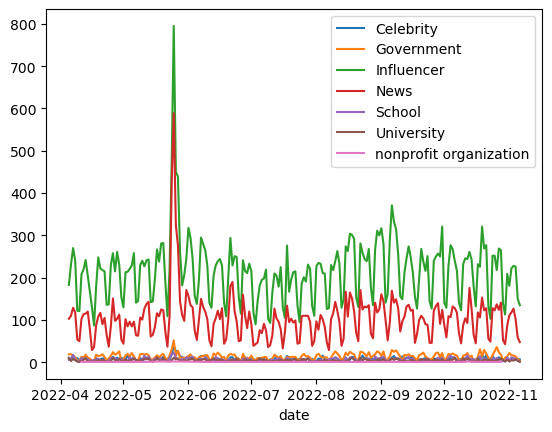

In [20]:
from matplotlib import pyplot as plt 
import datetime 

fig, ax = plt.subplots()
for label, grp in pd_timeseries.groupby('Organization'):
    grp.plot(x = 'date', y = 'count',ax = ax, label = label)
#     plt.set_xlim([datetime.date(2022, 4, 19), datetime.date(2022, 10, 25)])

In [15]:
timeseries2 = joined_df.select(["date"]).groupBy("date").count()

In [16]:
pd_timeseries2 = timeseries2.toPandas()

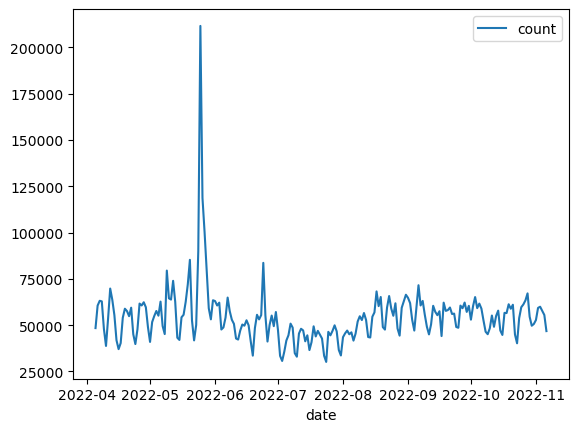

In [18]:
from matplotlib import pyplot as plt 
import datetime 
pd_timeseries2.plot(kind='line', x='date', y='count')
plt.show()